# Imports

In [1]:
import numpy as np
import sympy as sp
from sympy import *
import re

import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from math import log10, floor
from math import *
import math

from IPython.display import display, Latex
from IPython.display import Markdown as md

import scipy.constants as pc
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats

# Matplotlib Parameters

In [2]:
rcParams['font.size'] = 16
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True
plt.rcParams["figure.autolayout"] = True

# Selfcoded functions

In [3]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

# Formula for Gaussian error propagation with result
def DivisionMitFehler(A, deltaA, B, deltaB): # for C=A/B
    C = A/B
    deltaC = abs(C) * math.sqrt((deltaA / A)**2 + (deltaB / B)**2)
    return C,deltaC

def MultiplikationMitFehler(A, deltaA, B, deltaB): #for C=A*B
    C = A * B
    deltaC = abs(C) * ((deltaA / abs(A)) + (deltaB / abs(B)))
    return C, deltaC

# t-value for without literature value
def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)+(stu_2**2))))

# analytic linear regression y(x)=m*x + b calculates m
def bestM(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression y(x)=m*x + b calculates b
def bestB(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression calculates variance 
# (only used for next two functions, never gets called on its own, enhances readability) 
def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestB(x, y)+bestM(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

# analytic linear regression y(x)=m*x + b calculates error on m
def stuM(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

# analytic linear regression y(x)=m*x + b calculates error on b
def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

# Results of the experiment
Important notes on the code conventions:
- Variable names use CamelCase and are abbreviated, e.g., lenseDistanceObject corresponds to the distance of the lens from the object.
- Errors are indicated in CamelCase with the suffix Err, e.g., distanceErr corresponds to the error of the distance variable.
- Units are commented after the values, e.g., x = 3 # mm or "vMax = 2 # V."

In [4]:
# Directory

user = input("Wer ist am Apperat?: (J/P)")

if user == "J":
    os.chdir('C:\\Users\\Blubb\\Documents\\GitHub\\FP\\Jod')
else:
    os.chdir("C:\\Users\\MAYER\\Documents\\GitHub\\FP\\Jod")

Wer ist am Apperat?: (J/P)J


## Read lab data

In [5]:
intensitiesHg = np.loadtxt("spektrumHg.txt", usecols=1, skiprows=0, dtype='str')
#Hg = pd.read_csv("C:\\Users\\Pablo\\Documents\\FP\\Jod", sep=" ", header=None)
#intensitiesHg = Hg['946,18'].to_numpy()
intensitiesHg = np.char.replace(intensitiesHg, ',', '.').astype(float)
intensitiesHgErr = np.sqrt(intensitiesHg)
binsHg = np.arange(0, len(intensitiesHg), 1)
nBinsHg = len(binsHg)


intensitiesEmission = np.loadtxt("spektrumJodLED1Minute.txt", usecols=1, skiprows=0, dtype='str')
intensitiesEmission = np.char.replace(intensitiesEmission, ',', '.').astype(float)
intensitiesEmissionErr = np.sqrt(intensitiesEmission)
binsEmission = np.arange(0, len(intensitiesEmission), 1)
nBinsEmission = len(binsEmission)

intensitiesHalogen = np.loadtxt("spektrumHalogen.txt", usecols=1, skiprows=0, dtype='str')
intensitiesHalogen = np.char.replace(intensitiesHalogen, ',', '.').astype(float)
intensitiesHalogenErr = np.sqrt(intensitiesHalogen)
binsHalogen = np.arange(0, len(intensitiesHalogen), 1)
nBinsHalogen = len(binsHalogen)

intensitiesEmissionH = np.loadtxt("spektrumJodHA.txt", usecols=1, skiprows=0, dtype='str')
intensitiesEmissionH = np.char.replace(intensitiesEmissionH, ',', '.').astype(float)
intensitiesEmissionHErr = np.sqrt(intensitiesEmissionH)
binsEmissionH = np.arange(0, len(intensitiesEmissionH), 1)
nBinsEmissionH = len(binsEmissionH)

intensitiesNa = np.loadtxt("spektrumNA2.txt", usecols=1, skiprows=0, dtype='str')
intensitiesNa = np.char.replace(intensitiesNa, ',', '.').astype(float)
binsNa = np.arange(0, len(intensitiesNa), 1)
nBinsNa = len(binsNa)

intensitiesLED = np.loadtxt("spektrumLED.txt", usecols=1, skiprows=0, dtype='str')
intensitiesLED = np.char.replace(intensitiesLED, ',', '.').astype(float)
binsLED = np.arange(0, len(intensitiesLED), 1)
nBinsLED = len(binsLED)

intensitiesRed = np.loadtxt("spektrumRot.txt", usecols=1, skiprows=0, dtype='str')
intensitiesRed = np.char.replace(intensitiesRed, ',', '.').astype(float)
binsRed = np.arange(0, len(intensitiesRed), 1)
nBinsRed = len(binsRed)

intensitiesGreen = np.loadtxt("spektrumGrün.txt", usecols=1, skiprows=0, dtype='str')
intensitiesGreen = np.char.replace(intensitiesGreen, ',', '.').astype(float)
binsGreen = np.arange(0, len(intensitiesGreen), 1)
nBinsGreen = len(binsGreen)

intensitiesFluor = np.loadtxt("spektrumJodRed2.txt", usecols=1, skiprows=0, dtype='str')
intensitiesFluor = np.char.replace(intensitiesFluor, ',', '.').astype(float)
binsFluor = np.arange(0, len(intensitiesFluor), 1)
nBinsFluor = len(binsFluor)

## Plot lab data

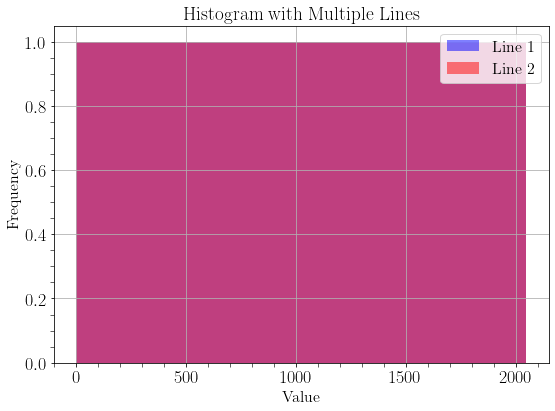

In [6]:
### Not sure was das hier ist worked nicht


# plt.figure(figsize=(8, 6))  # Set the size of the plot

# # Create histograms for both lines
# plt.hist(binsHg, bins=nBinsHg, alpha=0.5, color='blue', label='Line 1')
# plt.hist(binsNa, bins=nBinsNa, alpha=0.5, color='red', label='Line 2')

# # Add labels and legend
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.legend()

# # Add a title if needed
# plt.title('Histogram with Multiple Lines')

# # Customize other plot settings as desired
# # plt.grid(True)

# # Save the plot as a PDF file
# plt.savefig('Kalibratrionsspektren.pdf')

# # Show the plot (optional)
# plt.show()


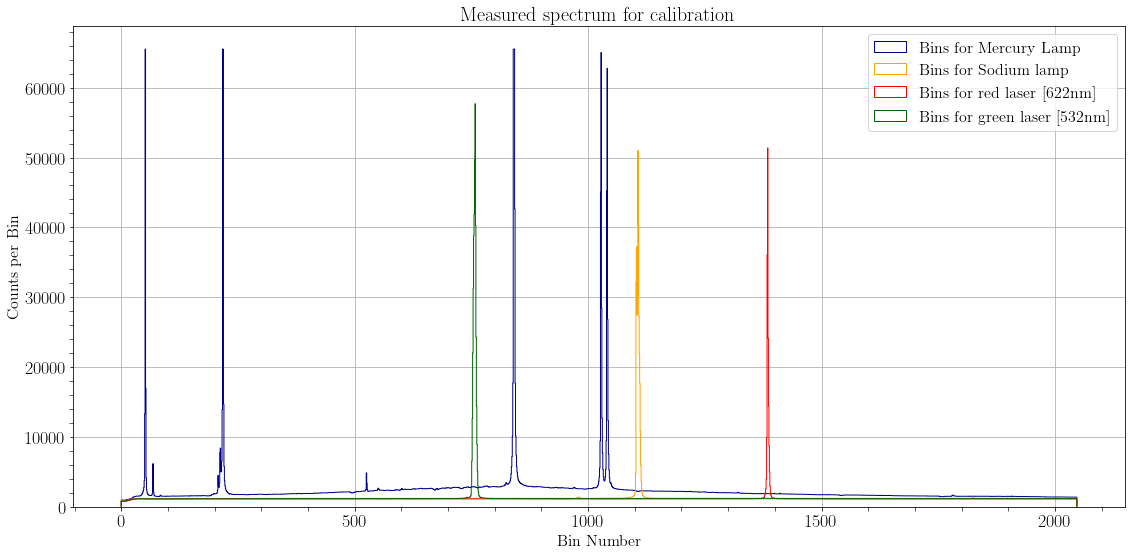

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

ax.hist(binsHg, bins=nBinsHg, histtype='step', color='darkblue', 
           weights=intensitiesHg, label=r'Bins for Mercury Lamp')



ax.hist(binsNa, bins=nBinsNa, histtype='step', color='orange', 
           weights=intensitiesNa, label=r'Bins for Sodium lamp')



ax.hist(binsRed, bins=nBinsRed, histtype='step', color='red', 
           weights=intensitiesRed, label=r'Bins for red laser [622nm]')


ax.hist(binsGreen, bins=nBinsGreen, histtype='step', color='darkgreen', 
           weights=intensitiesGreen, label=r'Bins for green laser [532nm]')


ax.set_xlabel(r'Bin Number', fontsize = 16)
ax.set_ylabel(r'Counts per Bin', fontsize = 16)
ax.set_title("Measured spectrum for calibration",fontsize=20)

# ax[0, 0].set(ylabel=r'Counts per Bin',xlabel=r'Bin Number',title="Measured spectrum of Sodium Lamp")
# ax[0, 0].set(ylabel=r'Counts per Bin',xlabel=r'Bin Number',title="Measured spectrum of red Laser")
# ax[0, 0].set(ylabel=r'Counts per Bin',xlabel=r'Bin Number',title="Measured spectrum of green Lamp")

ax.legend()
# ax[0, 0].legend()
# ax[0, 0].legend()
# ax[1, 1].legend()

fig.savefig("Kalibratrionsspektren.pdf")

## Calibration
Calibration was realized via measuring the known spectrums of the two (Na and Hg) calibration lamps. The data from these measurements was used to couple the bin numbers of peaks with the wavelengths of the corresponding known emission peaks and  linear regression was performed over all the points.

### Get calibration parameters via linear regression

758 1385
854.6652087991615
637.4712450362988
529.059328142384
637.6444270121676


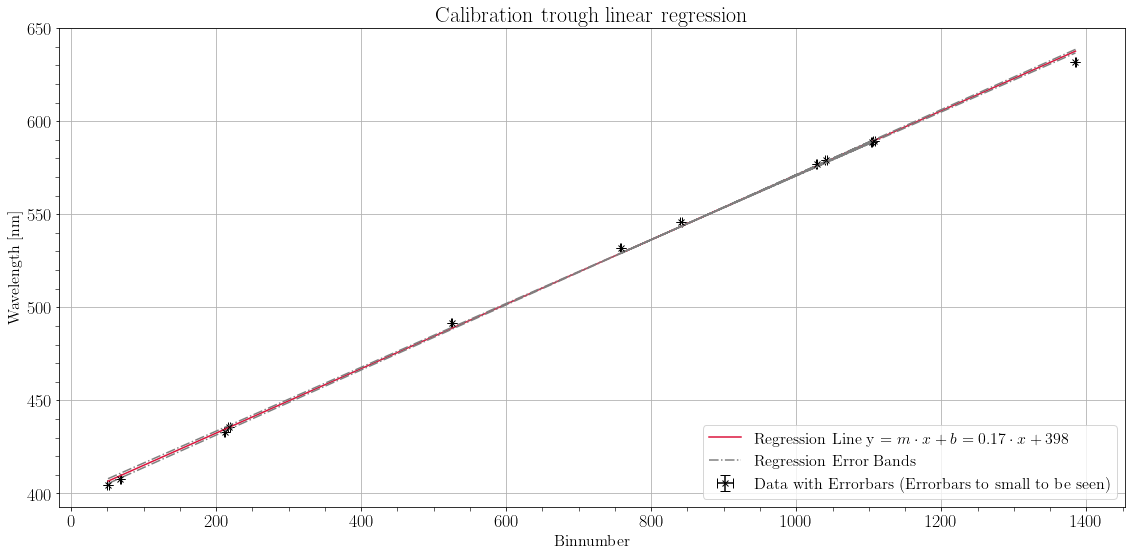

In [16]:
binNumbersHg = np.array([51, 68, 212, 218, 525, 841, 1028, 1041]) 
binNumbersNa = np.array([1104, 1107]) 
binNumbersLaser = np.array([intensitiesGreen.argmax(), intensitiesRed.argmax()])

print(intensitiesGreen.argmax(), intensitiesRed.argmax())

#binNumberLED = np.array()

# Source: Typical spectra of Oriel Spectral Lamps Oriel Optics Corporation 1 Market Street Stamford connecticut 06902
# Figure 36 & 35
wavelengthsHg = np.array([404.6, 407.78, 432.92, 435.84, 491.60, 546.07, 576.96, 579.07]) # nm 
wavelengthsNa = np.array([589.0, 589.6]) # nm
wavelengthsLaser = np.array([532.0, 632.0])


binNumbers = np.concatenate((binNumbersHg, binNumbersNa, binNumbersLaser))
binErr = 1
wavelengths = np.concatenate((wavelengthsHg, wavelengthsNa, wavelengthsLaser))

m = bestM(binNumbers, wavelengths)
b = bestB(binNumbers, wavelengths)
mErr = stuM(binNumbers, wavelengths)
bErr = stuB(binNumbers, wavelengths)

# Adjust plot size
fig, ax = plt.subplots(figsize=(16, 8))

#plt.figure(figsize=(16, 8))    

# Draw the Datapoints
# yerr = 0 because literature values
ax.errorbar(binNumbers, wavelengths, xerr=binErr,
             yerr=0, fmt='x', capsize=5, label='Data with Errorbars (Errorbars to small to be seen)', color='black')

# Draw the regression curve
ax.plot(binNumbers, m * binNumbers + b, color='crimson', 
         label=f'Regression Line y = $m\cdot x + b = {m:.2f}\cdot x + {b:.0f}$')

ax.plot(binNumbers, (m + mErr)* binNumbers - bErr + b, color='gray', ls='-.',
         label=f'Regression Error Bands')
ax.plot(binNumbers, (m - mErr)* binNumbers + bErr + b, color='gray', ls='-.')

# Axislabels
ax.set_xlabel(r'Binnumber',fontsize=16)
ax.set_ylabel(r'Wavelength [nm]',fontsize=16)
ax.set_title("Calibration trough linear regression",fontsize=22)

ax.legend(loc=4)


print((545.8-b)/m)
print(1384*m+b) # 632

print(intensitiesGreen.argmax()*m+b) # should be 522 nm
print(intensitiesRed.argmax()*m+b) # should be 632 nm
#while True:
#    eingabe = int(input("Angezeigte Wellenlänge: "))
#    print("Echte Wellenlänge",eingabe,"-->",eingabe*m+b)

fig.savefig("Kalibrationsgerade.pdf")

### Use Calibration parameters to calculate and plot accurate emission spectrum:

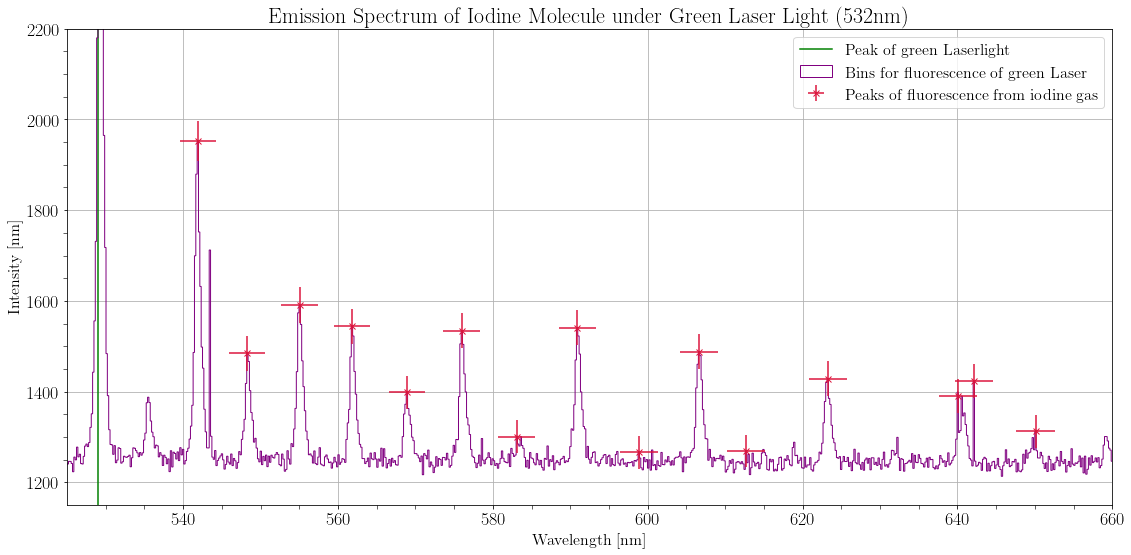

541.9 +- 2.3,  18454.44760329202 +- 78.88071436367647
548.3 +- 2.3,  18238.771981767586 +- 77.40903175344359
555.0 +- 2.3,  18016.829085106165 +- 75.90815922255551
561.8 +- 2.3,  17800.22278019678 +- 74.45665217126793
568.9 +- 2.4,  17578.05412703662 +- 72.98149623196677
576.0 +- 2.4,  17361.362983410032 +- 71.55600165050625
583.1 +- 2.4,  17149.949246232598 +- 70.17787455075786
590.9 +- 2.4,  16923.758485001763 +- 68.71725635199395
598.9 +- 2.4,  16698.62604410774 +- 67.27767396555002
606.6 +- 2.4,  16484.109186917012 +- 65.91915373456628
612.7 +- 2.4,  16321.035486482855 +- 64.89502580455161
623.3 +- 2.5,  16044.402614302739 +- 63.174730131009845
640.1 +- 2.5,  15623.316229454827 +- 60.59718664724562
642.1 +- 2.5,  15572.754421515718 +- 60.29102213410579
650.1 +- 2.5,  15381.928770435072 +- 59.14196288211178
[18454.44760329 18238.77198177 18016.82908511 17800.2227802
 17578.05412704 17361.36298341 17149.94924623 16923.758485
 16698.62604411 16484.10918692 16321.03548648 16044.4026143

In [17]:
binsFluorCal = binsFluor*m+b
binsFluorCalErr = binsFluor*mErr+bErr

# Adjust plot size
plt.figure(figsize=(16, 8))    

plt.axvline(x=529.059, color='green', label=r'Peak of green Laserlight')

# Draw the Datapoints
plt.hist(binsFluorCal, bins=nBinsFluor, histtype='step', color='purple', 
           weights=intensitiesFluor, label=r'Bins for fluorescence of green Laser')

peaksFluor = np.array([832, 869, 908, 947, 988, 1029, 1070, 1115, 1161, 1206, 1241, 1302, 1399, 1411, 1457]) # 1404  
peaksFluorIntensities = np.array([1951.54, 1484.84, 1590.16, 1543.82, 1398.00, 1534.46, 1300.64, 1541.01, 
                                  1265.76, 1487.88, 1268.8, 1428.66, 1389.81, 1422.81, 1312.81]) # 1352.83
peaksFluorIntensitiesErr = np.sqrt(peaksFluorIntensities)

nPeaksFluor = len(peaksFluor)
peaksFluorCal = peaksFluor*m+b
peaksFluorCalErr = peaksFluorCal*mErr+bErr

plt.errorbar(peaksFluorCal, peaksFluorIntensities, xerr=peaksFluorCalErr, yerr=peaksFluorIntensitiesErr, color='crimson', fmt='x',
         label=r'Peaks of fluorescence from iodine gas')

plt.xlim([525, 660])
plt.ylim([1150, 2200])

# Axislabels
plt.xlabel(r'Wavelength [nm]', fontsize=16)
plt.ylabel(r'Intensity [nm]', fontsize=16)
plt.title("Emission Spectrum of Iodine Molecule under Green Laser Light (532nm)", fontsize=22)

plt.legend()
plt.show()

peakWavenumber = 1/peaksFluorCal*1e7
peakWavenumberErr = peakWavenumber*(peaksFluorCalErr/peaksFluorCal)


for x in range(len(peaksFluorCal)):
    print(f'{peaksFluorCal[x]:.1f} +- {peaksFluorCalErr[x]:.1f},  {peakWavenumber[x]} +- {peakWavenumberErr[x]}')
    
print(1/peaksFluorCal*1e7)

fig.savefig("Emission Spectrum.pdf")

15


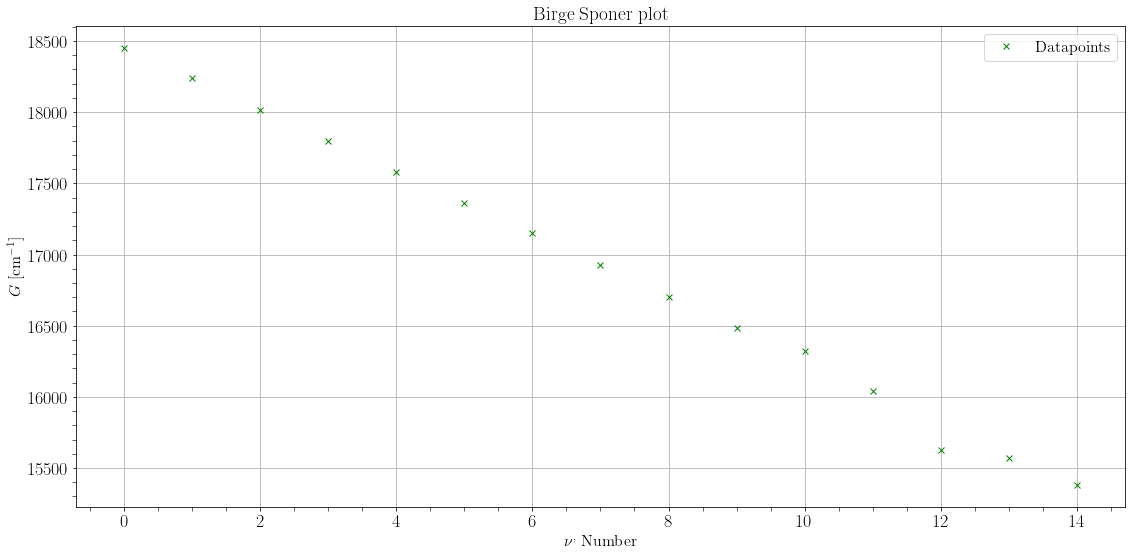

In [10]:
energy = (1/peaksFluorCal)*1e7

print(len(peaksFluorCal))
vibrationalN = np.arange(0, len(peaksFluorCal), 1)

# Adjust plot size
plt.figure(figsize=(16, 8))    

# Draw the Datapoints
plt.errorbar(vibrationalN, energy, color='green', fmt='x', label=r'Datapoints')

# Axislabels
plt.xlabel(r'$\nu^{,}$ Number')
plt.ylabel(r'$G$ [cm$^{-1}$]')
plt.title("Birge Sponer plot")

plt.legend()
plt.show()

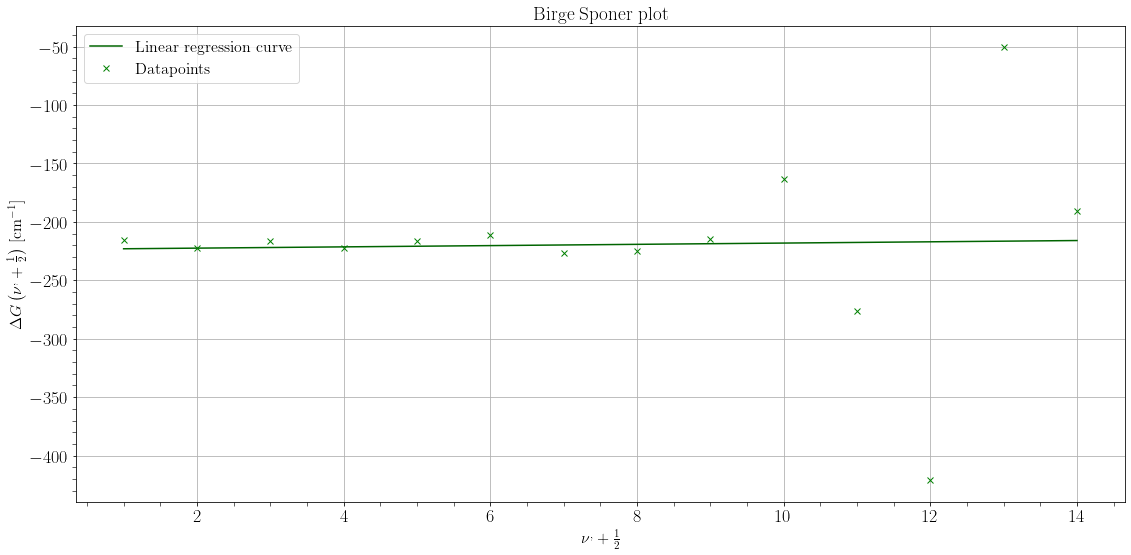

In [11]:
energyDiff = np.diff(energy)
vibrationalN = np.arange(1, len(peaksFluorCal), 1)

mBS = bestM(vibrationalN, energyDiff)
bBS = bestB(vibrationalN, energyDiff)
mBSErr = stuM(vibrationalN, energyDiff)
bBSErr = stuB(vibrationalN, energyDiff)

# Adjust plot size
plt.figure(figsize=(16, 8))    

# Draw the Datapoints
plt.errorbar(vibrationalN, energyDiff, color='green', fmt='x', label=r'Datapoints')

plt.plot(vibrationalN, vibrationalN*mBS+bBS, color='darkgreen', label=r'Linear regression curve')

# Axislabels
plt.xlabel(r'$\nu^{,} + \frac{1}{2} $')
plt.ylabel(r'$\Delta G \left( \nu^{,} + \frac{1}{2} \right)$ [cm$^{-1}$]')
plt.title("Birge Sponer plot")

plt.legend()
plt.show()

### Frank Condon Factors

In [12]:
FC

NameError: name 'FC' is not defined

## Absorptionsspektrum

In [ ]:
binsEmissionCal = binsEmission*m + b
binsEmissionHCal = binsEmissionH*m + b
binsEmissionHCalErr = binsEmissionH*mErr - bErr

bands = np.array([binsEmissionHCal[694], binsEmissionHCal[703], binsEmissionHCal[712],
                  binsEmissionHCal[721], binsEmissionHCal[731], binsEmissionHCal[742],
                  binsEmissionHCal[753], binsEmissionHCal[763], binsEmissionHCal[775],
                  binsEmissionHCal[787], binsEmissionHCal[800], binsEmissionHCal[813],
                  binsEmissionHCal[826], binsEmissionHCal[840], binsEmissionHCal[855], 
                  binsEmissionHCal[870], binsEmissionHCal[885]])

bandsErr = np.array([binsEmissionHCalErr[694], binsEmissionHCalErr[703], binsEmissionHCalErr[712],
                  binsEmissionHCalErr[721], binsEmissionHCalErr[731], binsEmissionHCalErr[742],
                  binsEmissionHCalErr[753], binsEmissionHCalErr[763], binsEmissionHCalErr[775],
                  binsEmissionHCalErr[787], binsEmissionHCalErr[800], binsEmissionHCalErr[813],
                  binsEmissionHCalErr[826], binsEmissionHCalErr[840], binsEmissionHCalErr[855], 
                  binsEmissionHCalErr[870], binsEmissionHCalErr[885]])

bandsIntensities = np.array([intensitiesEmissionH[694], intensitiesEmissionH[703], intensitiesEmissionH[712],
                             intensitiesEmissionH[721], intensitiesEmissionH[731], intensitiesEmissionH[742],
                             intensitiesEmissionH[753], intensitiesEmissionH[763], intensitiesEmissionH[775],
                             intensitiesEmissionH[787], intensitiesEmissionH[800], intensitiesEmissionH[813],
                             intensitiesEmissionH[826], intensitiesEmissionH[840], intensitiesEmissionH[855], 
                             intensitiesEmissionH[870], intensitiesEmissionH[885]])

plt.figure(figsize=(16, 8))   


plt.hist(binsEmissionCal, bins=nBinsEmission, histtype='step', color='darkblue', 
               weights=intensitiesEmission, label=r'Bins for Absorption of Iodine with an LED')

plt.hist(binsEmissionHCal, bins=nBinsEmissionH, histtype='step', color='crimson', 
               weights=intensitiesEmissionH, label=r'Bins for Absorption of Iodine with a Halogen Lamp')

plt.scatter(bands,bandsIntensities, color='red', label =r'Absorptionbands')

for i, x in enumerate(bands):
    plt.text(x+0.3, 2e4, r"$\nu^{,}$ %d" % (39-i), rotation=90, verticalalignment='center', color='r')


plt.vlines(x=bands, ymin=0, ymax=7e4, color = 'red', ls='--')
plt.vlines(x=bands+bandsErr, ymin=0, ymax=7e4, color = 'gray', ls='-.')
plt.vlines(x=bands-bandsErr, ymin=0, ymax=7e4, color = 'gray', ls='-.')

plt.xlim([516, 554])
plt.ylim([0, 7e4])

plt.xlabel(r'Wavelength [nm]')
plt.ylabel(r'Intensity')
plt.title("Absorption Spectrum of Iodine Molecule under Green Laser Light (532nm)")

plt.legend(loc=4, fontsize=18)
plt.show()

In [ ]:
bandWavenumbers = 1/bands*1e7
bandWavenumbersErr = bandWavenumbers*(bandsErr/bands)

print(bandWavenumbersErr)

energyDiffBands = np.array([])
energyDiffBandsErr = np.array([]) 

for i in range(len(bandWavenumbers)-1):
    energyDiffBands = np.append(energyDiffBands, bandWavenumbers[i+1] - bandWavenumbers[i]) 
    energyDiffBandsErr = np.append(energyDiffBandsErr, np.sqrt(bandWavenumbersErr[i+1]**2+bandWavenumbersErr[i]**2)) 
    
print(energyDiffBandsErr)
    
vibrationalNBands = np.arange(23.5, 39.5, 1)

mBS = bestM(vibrationalNBands, energyDiffBands)
bBS = bestB(vibrationalNBands, energyDiffBands)
mBSErr = stuM(vibrationalNBands, energyDiffBands)
bBSErr = stuB(vibrationalNBands, energyDiffBands)

# Adjust plot size
plt.figure(figsize=(16, 8))    

# Draw the Datapoints
plt.errorbar(vibrationalNBands, energyDiffBands, yerr=energyDiffBandsErr, color='red', fmt='x', label=r'Datapoints')

plt.plot(vibrationalNBands, vibrationalNBands*mBS+bBS, color='crimson', label=r'Linear regression curve')
plt.plot(vibrationalNBands, vibrationalNBands*(mBS+mBSErr)-bBSErr+bBS, color='gray', ls='-.', label=r'Linear regression error curves')
plt.plot(vibrationalNBands, vibrationalNBands*(mBS-mBSErr)+bBSErr+bBS, color='gray', ls='-.')

# Axislabels
plt.xlabel(r'$\nu^{,} + \frac{1}{2} $')
plt.ylabel(r'$\Delta G \left( \nu^{,} + \frac{1}{2} \right)$ [cm$^{-1}$]')
plt.title("Birge Sponer plot of Iodine absorption spectrum")

plt.legend()
plt.show()

display(Latex(f'$m = {mBS:.2f}+-{mBSErr:.2f}$ & $b = {bBS:.0f}+-{bBSErr:.0f}$'))

In [ ]:
omegaE = -mBS/2+bBS
omegaEErr = np.sqrt(bBSErr**2 + (mBSErr**2)/4)
omegaExE = -mBS/2
omegaExEErr = mBSErr/2


display(Latex(f"$\omega_{E}= {omegaE:.1f} \pm {omegaEErr:.1f}$ & $\omega_{E} x_{E}= {omegaExE:.1f}\pm {omegaExEErr:.1f}$"))

### Potential Depth

In [ ]:
nuDiss = - bBS/mBS - 1/2
nuDissErr = np.sqrt((bBSErr/bBS)**2 + (bBS/(mBS**2)*mBSErr)**2) 

ED1 = nuDiss*bBS/2
ED1Err = np.sqrt((bBS*nuDissErr/2)**2+(bBSErr*nuDiss/2)**2)

ED2 = (omegaE**2)/(4*omegaExE)
ED2Err =np.sqrt(((omegaE)/(2*omegaExE)*omegaEErr)**2 + ((omegaE**2)/(4*(omegaExE**2))*omegaExEErr)**2)

display(Latex(f"$\nu_{{Diss}} = {nuDiss:.1f} \pm {nuDissErr:.1f}$ &  $E_{{D,1}} = {ED1:.1f}\pm {ED1Err:.1f}$ & $E_{{D,2}} = {ED2:.1f}\pm {ED2Err:.1f}$"))

### Dissociation Energy

In [ ]:
binsEmissionCal = binsEmission*m + b
binsEmissionHCal = binsEmissionH*m + b
binsEmissionHCalErr = binsEmissionH*mErr - bErr

plt.figure(figsize=(16, 8))   

plt.hist(binsEmissionHCal, bins=nBinsEmissionH, histtype='step', color='crimson', 
               weights=intensitiesEmissionH-intensitiesHalogen+32600, label=r'Bins for Absorption of Iodine with a Halogen Lamp')

limitWavelength = 514
limitWavelengthErr = 2

plt.vlines(x=limitWavelength, ymin=0, ymax=1e4, color = 'red', ls='--', 
           label=f'Limit Wavelength $\lambda_{{diss}}$ of {limitWavelength} $\pm$ {limitWavelengthErr} nm')

plt.vlines(x=limitWavelength + limitWavelengthErr, ymin=0, ymax=1e4, color = 'gray', ls='-.', label='Limit Wavelength Error limiters')
plt.vlines(x=limitWavelength - limitWavelengthErr, ymin=0, ymax=1e4, color = 'gray', ls='-.')

plt.xlim([500, 530])
plt.ylim([0, 1e4])

plt.xlabel(r'Wavelength [nm]')
plt.ylabel(r'Intensity')
plt.title("Absorption Spectrum of Iodine Molecule under Green Laser Light (532nm)")

plt.legend(loc=1, fontsize=18)
plt.show()

In [ ]:
EDiss = 1/limitWavelength*1e6
EDissErr = limitWavelengthErr/limitWavelength*EDiss
display(Latex(f"$E_{{Diss}} = {EDiss:.1f} \pm {EDissErr:.1f}$"))

### Excitation Energy

In [ ]:
E0 = ED2 - omegaE/2 - omegaExE/2
E0Err = np.sqrt(ED2Err**2 + (omegaEErr**2/4) + (omegaExEErr/16))

EEx = EDiss - E0
EExErr = np.sqrt(EDissErr**2 + E0Err**2)

display(Latex(f"$E_{{0}} = {E0:.1f} \pm {E0Err:.1f}$ & $E_{{ex}} = E_{{Diss}} - E_{{0}} = {EEx:.1f} \pm {EExErr:.1f}$"))

### Morse Potential

In [ ]:
redMass = 1.05*1e-25
a = np.sqrt((4*pc.pi*pc.c*redMass*omegaExE)/(pc.hbar))/1e8
aErr = np.sqrt((4*pc.pi*pc.c*redMass)/(pc.hbar))*(omegaExEErr)/(2*np.sqrt(omegaExE))/1e8

display(Latex(f"$a = {a:.2f} \pm {aErr:.2f}$"))